<a href="https://colab.research.google.com/github/Axemazon/Finanzas/blob/main/Optimizer_Portfolios_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance numpy pandas scipy

**Optimizacion Por Black Litterman**

> Indented block



In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Función para calcular la relación negativa de Sharpe
def neg_sharpe(weights, returns3, cov_matrix):
    port_return = np.dot(weights, returns3)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = port_return / port_vol
    return -sharpe_ratio

# Función para descargar datos y calcular rendimientos y covarianza
def get_financial_data(tickers):
    data = yf.download(tickers, start='2023-01-01', end='2023-11-01')['Adj Close']
    returns3 = data.pct_change().dropna()
    annual_cov_matrix = returns3.cov() * 252
    return data, returns3, annual_cov_matrix

# Tickers seleccionados de la imagen proporcionada
tickers = ['AMR', 'ANET', 'BBW', 'CEIX', 'DECK', 'GNE', 'TREX', 'TNET', 'PARR', 'NVR','NVO']#11

# Descarga los datos históricos y calcula rendimientos y matriz de covarianza
price_data, returns3, annual_cov_matrix = get_financial_data(tickers)
average_returns = returns3.mean() * 252

# Vistas del inversor (debes definirlas según tu análisis)
# Asumiendo que las vistas son sobre el rendimiento anual
vistas = np.array([0.20, 0.15, 3.35])  # Rendimientos esperados para PARR, CEIX, TREX
P = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],  # Vista sobre PARR
    [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],  # Vista sobre CEIX
    [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]   # Vista sobre TREX
])

# Matriz diagonal para Omega (simplificación)
Omega = np.diag([0.1] * len(vistas))  # Asumir varianzas para las vistas

# Parámetros del modelo
tau = 0.05

# Cálculo de rendimientos implícitos del mercado (simplificado)
market_caps = price_data.mean()  # Suponiendo capitalizaciones de mercado basadas en precios promedio
pi = market_caps / market_caps.sum()

# Combinación de priors de mercado y vistas del inversor
M = np.linalg.inv(np.linalg.inv(tau * annual_cov_matrix) + np.dot(P.T, np.dot(np.linalg.inv(Omega), P)))
mu_bl = np.dot(M, np.dot(np.linalg.inv(tau * annual_cov_matrix), pi) + np.dot(P.T, np.dot(np.linalg.inv(Omega), vistas)))

# Optimización del portafolio
constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
               {'type': 'ineq', 'fun': lambda weights: weights - 0.01},
               {'type': 'ineq', 'fun': lambda weights: 0.25 - weights})
bounds = tuple((0, 1) for asset in range(len(tickers)))
initial_weights = np.array([1/len(tickers)]*len(tickers))

opt_result = minimize(neg_sharpe, initial_weights, args=(mu_bl, annual_cov_matrix), method='SLSQP', bounds=bounds, constraints=constraints)

# Pesos óptimos del portafolio
optimal_weights3 = opt_result.x

# Mostrar resultados
print("Ponderaciones óptimas:")
for ticker, weight in zip(tickers, optimal_weights3):
    print(f"{ticker}: {weight:.4f}")

# Calcular el rendimiento acumulado del portafolio con los pesos óptimos
portfolio_cumulative_return = (returns3 + 1).cumprod().dot(optimal_weights3)

# Mostrar el rendimiento acumulado al final del periodo
print(f"\nRendimiento acumulado del portafolio al final del periodo: {portfolio_cumulative_return.iloc[-1]:.4f}")



[*********************100%%**********************]  11 of 11 completed
Ponderaciones óptimas:
AMR: 0.0100
ANET: 0.0239
BBW: 0.0441
CEIX: 0.0121
DECK: 0.1960
GNE: 0.0160
TREX: 0.2500
TNET: 0.2500
PARR: 0.0584
NVR: 0.1296
NVO: 0.0100

Rendimiento acumulado del portafolio al final del periodo: 1.4044


**Optimizacion Markowits**

In [ ]:
import yfinance as yf
import numpy as np
import cvxpy as cp

# Descargar datos de precios de cierre ajustados de acciones
tickers = ['AMR', 'ANET', 'BBW', 'CEIX', 'DECK', 'GNE', 'TREX', 'TNET', 'PARR', 'NVR','NVO']
data = yf.download(tickers, start='2023-01-01', end='2023-11-01')['Adj Close']

# Calcular rendimientos diarios
returns = np.log(data / data.shift(1)).dropna()

# Número de activos
num_assets = len(tickers)

# Variables de ponderación (a optimizar)
weights = cp.Variable(num_assets)

# Covarianza de los rendimientos
cov_matrix = np.cov(returns, rowvar=False)

# Rendimiento esperado
expected_return = cp.sum(cp.multiply(weights, returns.mean()))

# Volatilidad (varianza) del portafolio
portfolio_variance = cp.quad_form(weights, cov_matrix)

# Reformulación de la función objetivo
objective = cp.Minimize(portfolio_variance)

# Restricciones de la optimización
constraints = [
    cp.sum(weights) == 1,  # La suma de las ponderaciones es 1
    weights >= 0.01,  # Las ponderaciones son no negativas
    weights <= 0.2,  # Por ejemplo, cada acción no puede tener más del 20% del portafolio
]

# Problema de optimización
problem = cp.Problem(objective, constraints)

# Resolver el problema
problem.solve()

# Mostrar resultados
optimal_weights = weights.value
portfolio_return = expected_return.value
portfolio_volatility = np.sqrt(portfolio_variance.value)

print("Ponderaciones óptimas:")
for i in range(num_assets):
    print(f"{tickers[i]}: {optimal_weights[i]:.4f}")

print(f"\nRendimiento esperado del portafolio: {portfolio_return:.4f}")
print(f"Volatilidad esperada del portafolio: {portfolio_volatility:.4f}")

[*********************100%%**********************]  11 of 11 completed
Ponderaciones óptimas:
AMR: 0.0100
ANET: 0.0389
BBW: 0.0716
CEIX: 0.0155
DECK: 0.1960
GNE: 0.0120
TREX: 0.2000
TNET: 0.2000
PARR: 0.0706
NVR: 0.1754
NVO: 0.0100

Rendimiento esperado del portafolio: 0.0016
Volatilidad esperada del portafolio: 0.0104


**Optimizacion por CAPM**

In [ ]:
import yfinance as yf
import numpy as np
import cvxpy as cp

# Lista de símbolos de activos (puedes cambiarlos según tus necesidades)
tickers = ['AMR', 'ANET', 'BBW', 'CEIX', 'DECK', 'GNE', 'TREX', 'TNET', 'PARR', 'NVR','NVO', '^GSPC']

# Descargar datos de precios de cierre ajustados
data = yf.download(tickers, start='2023-01-01', end='2023-11-01')['Adj Close']

# Calcular rendimientos diarios
#returns = data.pct_change().dropna()
returns1 = np.log(data / data.shift(1)).dropna()

# Número de activos
num_assets = len(tickers)

# Variables de ponderación (a optimizar)
weights = cp.Variable(num_assets)

# Covarianza de los rendimientos
cov_matrix = np.cov(returns1, rowvar=False)

# Calcular rendimientos esperados usando CAPM
risk_free_rate = 0.02  # Tasa libre de riesgo (ejemplo)
market_return = yf.download('^GSPC', start='2023-01-01', end='2023-11-01')['Adj Close'].pct_change().dropna().mean()
market_risk_premium = market_return - risk_free_rate

# Beta de cada acción con respecto al mercado
betas = [np.cov(returns1[ticker], returns1['^GSPC'])[0, 1] / np.var(returns1['^GSPC']) for ticker in tickers]

# Rendimientos esperados usando CAPM
expected_returns_capm = risk_free_rate + np.array(betas) * market_risk_premium

# Rendimiento esperado
expected_return = cp.sum(cp.multiply(weights, expected_returns_capm))

# Volatilidad (varianza) del portafolio
portfolio_variance = cp.quad_form(weights, cov_matrix)

# Reformulación de la función objetivo
objective = cp.Maximize(expected_return - 0.5 * portfolio_variance)

# Restricciones de la optimización
constraints = [
    cp.sum(weights) == 1,  # La suma de las ponderaciones es 1
    weights >= 0.02, # Mínimo 2%
    weights <= 0.2,  # Máximo 20%
]

# Problema de optimización
problem = cp.Problem(objective, constraints)

# Resolver el problema
problem.solve()

# Mostrar resultados
optimal_weights1 = weights.value
portfolio_return = expected_return.value
portfolio_volatility = np.sqrt(portfolio_variance.value)

print("Ponderaciones óptimas:")
for i in range(num_assets):
    print(f"{tickers[i]}: {optimal_weights1[i]:.4f}")

print(f"\nRendimiento esperado del portafolio: {portfolio_return:.4f}")
print(f"Volatilidad esperada del portafolio: {portfolio_volatility:.4f}")

[*********************100%%**********************]  12 of 12 completed
[*********************100%%**********************]  1 of 1 completed
Ponderaciones óptimas:
AMR: 0.0200
ANET: 0.0200
BBW: 0.2000
CEIX: 0.0200
DECK: 0.2000
GNE: 0.0600
TREX: 0.0200
TNET: 0.0200
PARR: 0.2000
NVR: 0.0200
NVO: 0.2000
^GSPC: 0.0200

Rendimiento esperado del portafolio: 0.0055
Volatilidad esperada del portafolio: 0.0134


**Optimizacion Markowits encontrando frontera eficiente**

[*********************100%%**********************]  11 of 11 completed
Ponderaciones óptimas:
AMR: 0.0000
ANET: 0.0378
BBW: 0.0636
CEIX: 0.0181
DECK: 0.1803
GNE: 0.0117
TREX: 0.1879
TNET: 0.2756
PARR: 0.0665
NVR: 0.1586
NVO: 0.0000

Rendimiento esperado del portafolio: 0.0015
Volatilidad esperada del portafolio: 0.0103


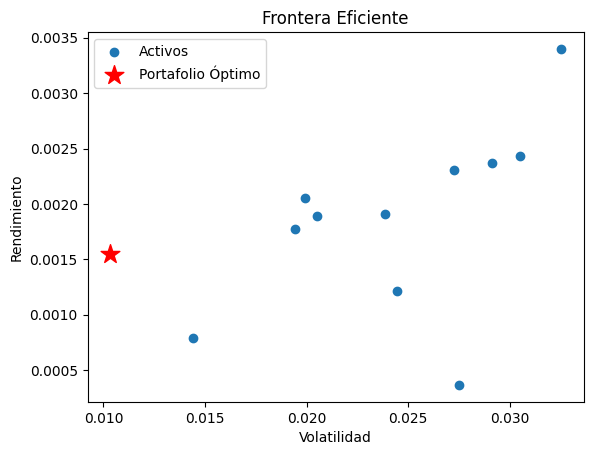

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Lista de símbolos de activos (puedes cambiarlos según tus necesidades)
tickers = ['AMR', 'ANET', 'BBW', 'CEIX', 'DECK', 'GNE', 'TREX', 'TNET', 'PARR', 'NVR','NVO']

# Descargar datos de precios de cierre ajustados
data = yf.download(tickers, start='2023-01-01', end='2023-11-01')['Adj Close']

# Número de activos
num_assets = len(tickers)

# Calcular rendimientos diarios
returns2 = np.log(data / data.shift(1)).dropna()

# Calcular rendimiento esperado y matriz de covarianza
rendimientos = returns.mean().values
matriz_covarianza = returns.cov().values

# Función objetivo para minimizar la volatilidad del portafolio
def volatilidad(weights, cov_matrix):
    return np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

# Restricciones para los pesos del portafolio
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Rango de pesos (entre 0 y 1)
bounds = tuple((0, 1) for asset in range(len(rendimientos)))

# Rendimiento objetivo para la optimización
rendimiento_objetivo = 0.018

# Optimización para encontrar la frontera eficiente
optimal_portfolio = minimize(volatilidad, len(rendimientos)*[1./len(rendimientos),], args=(matriz_covarianza,),
                             method='SLSQP', bounds=bounds, constraints=constraints)

# Resultados de la optimización
pesos_optimos = optimal_portfolio['x']
rendimiento_optimo = np.dot(rendimientos, pesos_optimos)
volatilidad_optima = volatilidad(pesos_optimos, matriz_covarianza)

print("Ponderaciones óptimas:")
for i in range(num_assets):
    print(f"{tickers[i]}: {pesos_optimos[i]:.4f}")

print(f"\nRendimiento esperado del portafolio: {rendimiento_optimo:.4f}")
print(f"Volatilidad esperada del portafolio: {volatilidad_optima:.4f}")

# Gráfico de la frontera eficiente
plt.scatter(np.sqrt(np.diagonal(matriz_covarianza)), rendimientos, label='Activos')
plt.scatter(volatilidad_optima, rendimiento_optimo, color='red', marker='*', s=200, label='Portafolio Óptimo')
plt.title('Frontera Eficiente')
plt.xlabel('Volatilidad')
plt.ylabel('Rendimiento')
plt.legend()
plt.show()

**Portafolio Benchmark Invertir el 100% en el S&P500**

In [ ]:
import yfinance as yf
import numpy as np
import cvxpy as cp

# Lista de símbolos de activos (puedes cambiarlos según tus necesidades)
tickers = ['^GSPC']

# Descargar datos de precios de cierre ajustados
data = yf.download(tickers, start='2023-01-01', end='2023-11-01')['Adj Close']

# Calcular rendimientos diarios
returns4 = np.log(data / data.shift(1)).dropna()


# Variables de ponderación (a optimizar)
weights5 = 1.0



[*********************100%%**********************]  1 of 1 completed


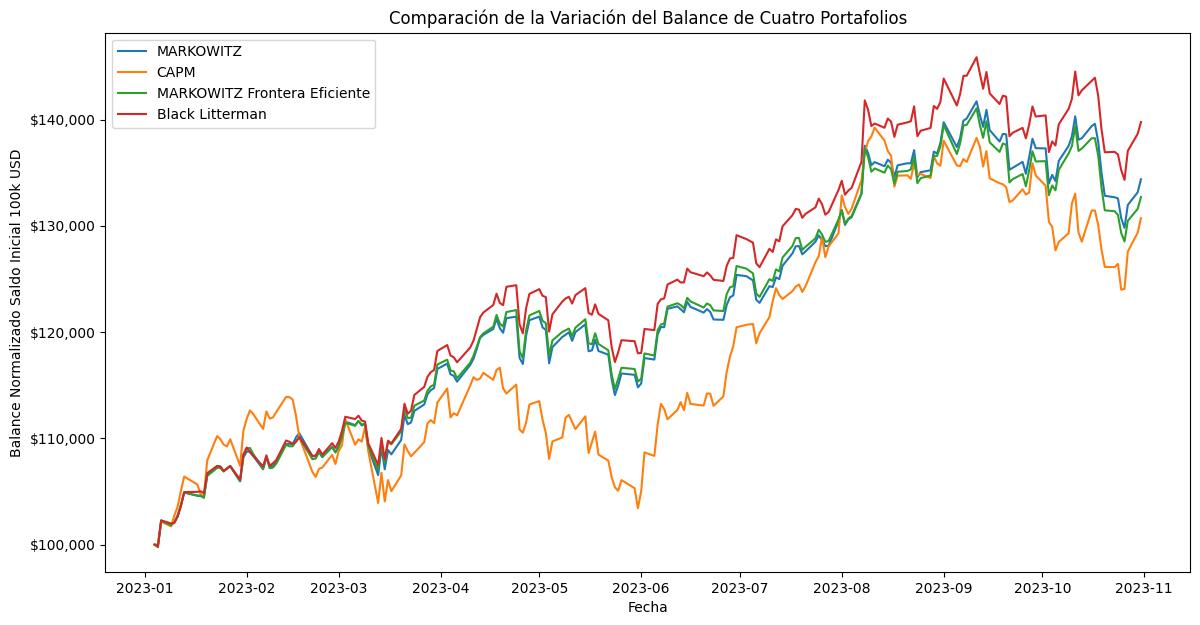

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# # Define los tickers de los activos del portafolio
# tickers = ['AMR', 'ANET', 'BBW', 'CEIX', 'DECK', 'GNE', 'TREX', 'TNET', 'PARR', 'NVR','NVO', '^GSPC']

# # Descarga los datos históricos de los activos
# data = yf.download(tickers,  start='2023-01-01', end='2023-11-01')['Adj Close']

# # Calcula los rendimientos diarios
# returns = np.log(data / data.shift(1)).dropna()

# Define los pesos para tres portafolios diferentes
weights_portfolio_1 = np.array(optimal_weights)
weights_portfolio_2 = np.array(optimal_weights1)
weights_portfolio_3 = np.array(pesos_optimos)
weights_portfolio_4 = np.array(opt_result.x)




# Calcula el balance acumulado para cada portafolio
balance_portfolio_1 = (returns + 1).cumprod().dot(weights_portfolio_1)
balance_portfolio_2 = (returns1 + 1).cumprod().dot(weights_portfolio_2)
balance_portfolio_3 = (returns2 + 1).cumprod().dot(weights_portfolio_3)
balance_portfolio_4 = (returns3 + 1).cumprod().dot(weights_portfolio_4)



# Normaliza los balances al primer día para que comiencen en el mismo punto
normalized_balance_1 = balance_portfolio_1 / balance_portfolio_1.iloc[0]*100000
normalized_balance_2 = balance_portfolio_2 / balance_portfolio_2.iloc[0]*100000
normalized_balance_3 = balance_portfolio_3 / balance_portfolio_3.iloc[0]*100000
normalized_balance_4 = balance_portfolio_4 / balance_portfolio_4.iloc[0]*100000



def money_format(x, pos):
    return '${:,.0f}'.format(x)

# Configurar el formato del eje y
formatter = FuncFormatter(money_format)


# Graficar la comparación de los tres portafolios
plt.figure(figsize=(14, 7))
plt.plot(normalized_balance_1, label='MARKOWITZ')
plt.plot(normalized_balance_2, label='CAPM')
plt.plot(normalized_balance_3, label='MARKOWITZ Frontera Eficiente')
plt.plot(normalized_balance_4, label='Black Litterman')
plt.title('Comparación de la Variación del Balance de Cuatro Portafolios')
plt.xlabel('Fecha')
plt.ylabel('Balance Normalizado Saldo Inicial 100k USD')
plt.gca().yaxis.set_major_formatter(formatter)
plt.legend()
plt.show()